# Compare RandomForest vs XGBoost on your local exoplanet CSVs

It expects you to set local file paths for KOI / TOI / K2 CSVs. The notebook will:

- Load the CSVs you specify (no web downloads).
- Standardize a common feature set and binary label (`planet` vs `not-planet`).
- Show detailed data statistics so you can decide how to balance the dataset.
- Provide helper functions to undersample/oversample or use SMOTE (if `imblearn` installed).
- Train both a RandomForest and an XGBoost model with timing printed to the console.
- Compare performance (classification report, ROC-AUC, confusion matrix) and training time.

**How to use:**

1. Edit the `DATA_PATHS` dictionary cell to point to your local CSV files.
2. Run the notebook from top to bottom. Adjust balancing options in the 'Balance options' cell.


In [ ]:

# Install required packages if missing. Comment out if already installed in your environment.
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn xgboost matplotlib seaborn imbalanced-learn joblib
print('Dependencies installed / available.')


In [1]:

# === EDIT THESE PATHS to point to your local CSV files ===
DATA_PATHS = {
    'KOI': 'data/kepler_koi.csv',
    'TOI': 'data/tess_toi.csv'
    # 'K2' : 'data/k2pandc.csv'
}
for k,v in DATA_PATHS.items():
    print(k, '->', v)


KOI -> data/kepler_koi.csv
TOI -> data/tess_toi.csv


In [6]:

# Load CSVs (paths provided above) and standardize to a common schema
import pandas as pd, numpy as np, os
def load_csv(path):
    if path is None:
        return pd.DataFrame()
    if not os.path.exists(path):
        print('WARNING: path not found:', path)
        return pd.DataFrame()
    return pd.read_csv(path)

df_koi = load_csv(DATA_PATHS.get('KOI'))
df_toi = load_csv(DATA_PATHS.get('TOI'))
# df_k2  = load_csv(DATA_PATHS.get('K2'))

def standardize_koi(df):
    out = pd.DataFrame()
    out['id'] = df.get('kepoi_name')
    disp = df.get('koi_disposition').astype(str).str.upper() if 'koi_disposition' in df.columns else pd.Series([np.nan]*len(df))
    out['label'] = disp.replace({'CANDIDATE':1,'CONFIRMED':1,'FALSE POSITIVE':0,'FALSE_POSITIVE':0})
    out['period'] = pd.to_numeric(df.get('koi_period'), errors='coerce')
    out['duration'] = pd.to_numeric(df.get('koi_duration'), errors='coerce')
    out['depth'] = pd.to_numeric(df.get('koi_depth'), errors='coerce')
    out['prad'] = pd.to_numeric(df.get('koi_prad'), errors='coerce')
    out['snr'] = pd.to_numeric(df.get('koi_model_snr'), errors='coerce') if 'koi_model_snr' in df.columns else np.nan
    out['st_teff'] = np.nan
    out['st_rad'] = np.nan
    return out

def standardize_toi(df):
    out = pd.DataFrame()
    out['id'] = df.get('toi')
    disp = df.get('tfopwg_disp').astype(str).str.upper() if 'tfopwg_disp' in df.columns else pd.Series([np.nan]*len(df))
    out['label'] = disp.replace({'PC':1,'KP':1,'CONFIRMED':1,'CANDIDATE':1,'FP':0,'FALSE POSITIVE':0})
    out['period'] = pd.to_numeric(df.get('pl_orbper'), errors='coerce')
    out['duration'] = pd.to_numeric(df.get('pl_trandurh'), errors='coerce')
    out['depth'] = pd.to_numeric(df.get('pl_trandep'), errors='coerce')
    out['prad'] = pd.to_numeric(df.get('pl_rade'), errors='coerce')
    out['snr'] = np.nan
    out['st_teff'] = pd.to_numeric(df.get('st_teff'), errors='coerce') if 'st_teff' in df.columns else np.nan
    out['st_rad'] = pd.to_numeric(df.get('st_rad'), errors='coerce') if 'st_rad' in df.columns else np.nan
    return out

# def standardize_k2(df):
#     out = pd.DataFrame()
#     out['id'] = df.get('pl_name')
#     disp = df.get('disposition').astype(str).str.upper() if 'disposition' in df.columns else pd.Series([np.nan]*len(df))
#     out['label'] = disp.replace({'CANDIDATE':1,'CONFIRMED':1,'FALSE POSITIVE':0,'FALSE_POSITIVE':0,'FALSE_POSITIVE?':0})
#     out['period'] = pd.to_numeric(df.get('pl_orbper'), errors='coerce')
#     out['duration'] = pd.to_numeric(df.get('pl_trandur'), errors='coerce')
#     out['depth'] = pd.to_numeric(df.get('pl_trandepl'), errors='coerce')
#     out['prad'] = pd.to_numeric(df.get('pl_rade'), errors='coerce')
#     out['snr'] = np.nan
#     out['st_teff'] = pd.to_numeric(df.get('st_teff'), errors='coerce') if 'st_teff' in df.columns else np.nan
#     out['st_rad'] = pd.to_numeric(df.get('st_rad'), errors='coerce') if 'st_rad' in df.columns else np.nan
#     return out

std_koi = standardize_koi(df_koi) if not df_koi.empty else pd.DataFrame()
std_toi = standardize_toi(df_toi) if not df_toi.empty else pd.DataFrame()
# std_k2  = standardize_k2(df_k2) if not df_k2.empty else pd.DataFrame()

print('Standardized shapes:')
print('KOI:', std_koi.shape, 'TOI:', std_toi.shape)

# Show top rows for sanity
for name, sd in [('KOI', std_koi), ('TOI', std_toi)]:
    print('\n---', name, 'sample ---')
    display(sd.head(3))


Standardized shapes:
KOI: (9564, 9) TOI: (7703, 9)

--- KOI sample ---


C:\Users\RAJ DAVE\AppData\Local\Temp\ipykernel_30576\688757337.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out['label'] = disp.replace({'CANDIDATE':1,'CONFIRMED':1,'FALSE POSITIVE':0,'FALSE_POSITIVE':0})


,id,label,period,duration,depth,prad,snr,st_teff,st_rad
0,K00752.01,1,9.488036,2.9575,615.8,2.26,35.8,NaN,NaN
1,K00752.02,1,54.418383,4.5070,874.8,2.83,25.8,NaN,NaN
2,K00753.01,1,19.899140,1.7822,10829.0,14.60,76.3,NaN,NaN



--- TOI sample ---


,id,label,period,duration,depth,prad,snr,st_teff,st_rad
0,1049.01,1,2.180528,2.969175,16340.135320,16.808853,NaN,6599.0,1.27146
1,105.01,1,2.184667,2.865280,11708.022855,13.702853,NaN,5630.0,1.23824
2,1050.01,1,3.735484,4.142000,17030.000000,21.231500,NaN,6650.0,1.57000


In [9]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


=== KOI ===
Shape: (9564, 9)
Label counts:
label
0    4839
1    4725
Name: count, dtype: int64

Missing values per column:
id             0
label          0
period         0
duration       0
depth        363
prad         363
snr          363
st_teff     9564
st_rad      9564
dtype: int64

Descriptive stats (numeric columns):


,label,period,duration,depth,prad,snr,st_teff,st_rad
count,9564.000000,9564.000000,9564.000000,9.201000e+03,9201.000000,9201.000000,0.0,0.0
mean,0.494040,75.671358,5.621606,2.379134e+04,102.891778,259.895001,NaN,NaN
std,0.499991,1334.744046,6.471554,8.224268e+04,3077.639126,795.806615,NaN,NaN
min,0.000000,0.241843,0.052000,0.000000e+00,0.080000,0.000000,NaN,NaN
25%,0.000000,2.733684,2.437750,1.599000e+02,1.400000,12.000000,NaN,NaN
50%,0.000000,9.752831,3.792600,4.211000e+02,2.390000,23.000000,NaN,NaN
75%,1.000000,40.715178,6.276500,1.473400e+03,14.930000,78.000000,NaN,NaN
max,1.000000,129995.778400,138.540000,1.541400e+06,200346.000000,9054.700000,NaN,NaN


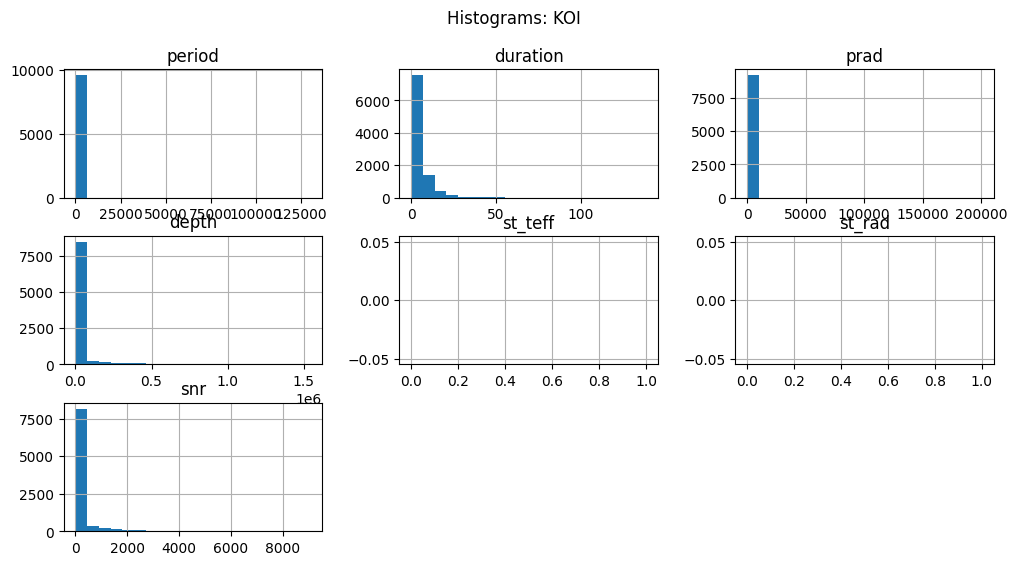

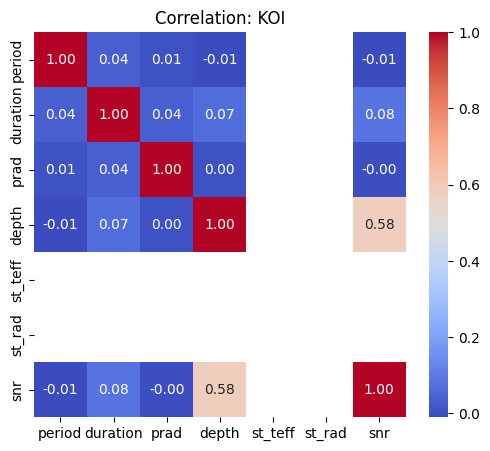

=== TOI ===
Shape: (7703, 9)
Label counts:
label
1      5262
0      1197
CP      684
APC     462
FA       98
Name: count, dtype: int64

Missing values per column:
id             0
label          0
period       107
duration       0
depth          0
prad         506
snr         7703
st_teff      161
st_rad       507
dtype: int64

Descriptive stats (numeric columns):


,id,period,duration,depth,prad,snr,st_teff,st_rad
count,7703.000000,7596.000000,7703.000000,7703.000000,7197.000000,0.0,7542.000000,7196.000000
mean,3749.039313,17.740126,3.059219,8256.682976,10.326826,NaN,5791.480883,1.403747
std,2152.357244,97.737493,1.873805,17502.275805,8.527090,NaN,1481.355241,1.598079
min,101.010000,0.152076,0.101000,24.583493,0.552507,NaN,2808.000000,0.114827
25%,1861.510000,2.490985,1.846000,1418.165449,4.495591,NaN,5211.000000,0.890000
50%,3736.010000,4.088722,2.732000,4750.326457,10.544000,NaN,5800.550000,1.234340
75%,5615.510000,7.924365,3.798500,10350.821195,14.019400,NaN,6295.650000,1.660000
max,7509.010000,1837.889731,30.015619,767910.313098,297.111726,NaN,50000.000000,102.030000


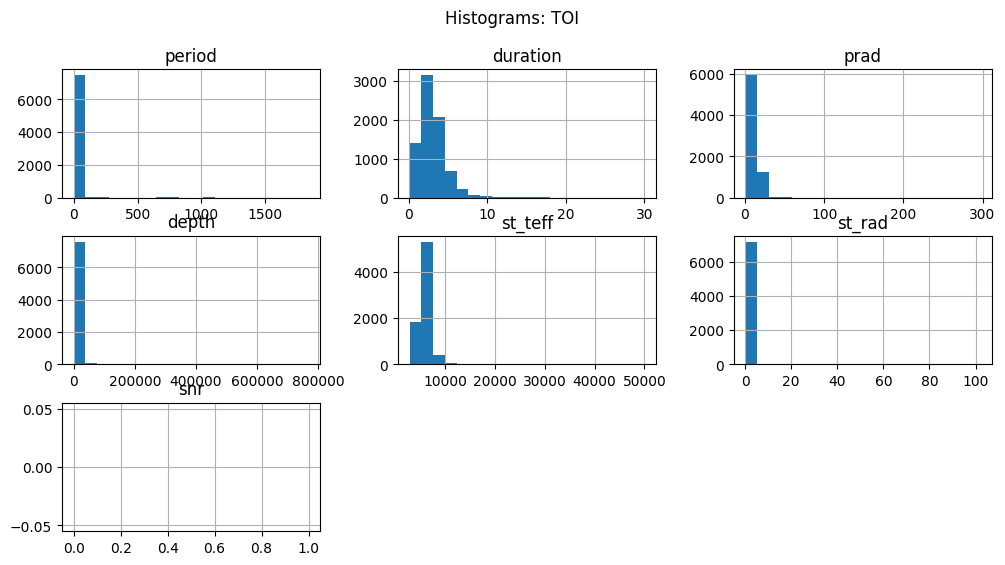

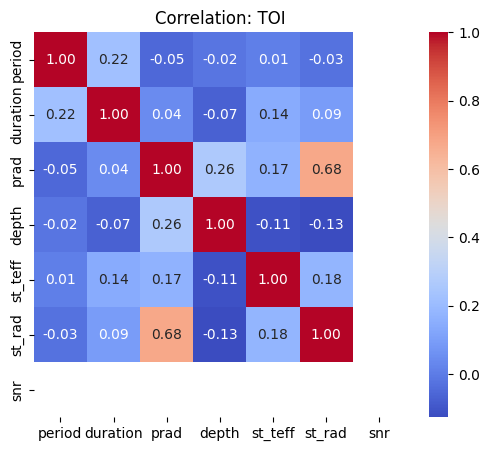

In [10]:

# Data statistics: label counts, missing values, descriptive stats, histograms, correlations
import matplotlib.pyplot as plt, seaborn as sns
def data_stats(df, name):
    print(f'=== {name} ===')
    print('Shape:', df.shape)
    print('Label counts:')
    print(df['label'].value_counts(dropna=False))
    print('\nMissing values per column:')
    print(df.isna().sum())
    print('\nDescriptive stats (numeric columns):')
    display(df.describe())
    featcols = ['period','duration','prad','depth','st_teff','st_rad','snr']
    present = [c for c in featcols if c in df.columns]
    if present:
        df[present].hist(bins=20, figsize=(12,6))
        plt.suptitle(f'Histograms: {name}')
        plt.show()
    if len(present) >= 2:
        plt.figure(figsize=(6,5))
        sns.heatmap(df[present].corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Correlation: {name}')
        plt.show()

for name, df in [('KOI', std_koi), ('TOI', std_toi)]:
    if df.empty:
        print(name, 'missing - skipping stats')
    else:
        data_stats(df, name)


In [11]:

# Balancing helpers: undersample majority, oversample minority, SMOTE (if available)
from sklearn.utils import resample
def undersample(df, target_col='label', random_state=42):
    df = df.dropna(subset=[target_col])
    counts = df[target_col].value_counts()
    if len(counts) < 2:
        print('Not enough classes to undersample.')
        return df
    min_count = counts.min()
    parts = []
    for cls, grp in df.groupby(target_col):
        parts.append(grp.sample(min_count, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)

def oversample(df, target_col='label', random_state=42):
    df = df.dropna(subset=[target_col])
    counts = df[target_col].value_counts()
    if len(counts) < 2:
        print('Not enough classes to oversample.')
        return df
    max_count = counts.max()
    parts = []
    for cls, grp in df.groupby(target_col):
        parts.append(grp.sample(max_count, replace=True, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)

def try_smote(X, y):
    try:
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=42)
        Xs, ys = sm.fit_resample(X, y)
        print('SMOTE applied. New shape:', Xs.shape)
        return Xs, ys
    except Exception as e:
        print('SMOTE not available or failed:', e)
        return X, y

print('Balancing helper functions defined.')


Balancing helper functions defined.


In [12]:

# Train and compare RandomForest vs XGBoost on a given standardized df
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

def prepare_features(df, featcols=None):
    if featcols is None:
        featcols = ['period','duration','prad','depth','st_teff','st_rad','snr']
    present = [c for c in featcols if c in df.columns]
    X = df[present].copy()
    y = df['label'].astype(int)
    return X, y, present

def evaluate_and_plot(y_test, y_pred, y_proba=None, title='Model'):
    print(classification_report(y_test, y_pred))
    if y_proba is not None and len(set(y_test))==2:
        try:
            auc = roc_auc_score(y_test, y_proba)
            print('ROC AUC:', auc)
        except Exception as e:
            print('ROC AUC error:', e)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-planet','planet'])
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def train_compare(df_std, name='dataset', balance_method=None, random_state=42):
    df = df_std.dropna(subset=['label']).copy()
    df = df[df['label'].isin([0,1])].copy()
    if df.shape[0] < 30:
        print(name, 'too few samples after filtering:', df.shape[0])
        return None
    # apply balancing if requested
    if balance_method == 'undersample':
        df = undersample(df, 'label', random_state=random_state)
        print('After undersample, class counts:', df['label'].value_counts())
    elif balance_method == 'oversample':
        df = oversample(df, 'label', random_state=random_state)
        print('After oversample, class counts:', df['label'].value_counts())
    X, y, present = prepare_features(df)
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)
    # pipeline wrappers
    pipe_rf = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=random_state, n_jobs=-1))
    pipe_xgb = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=random_state, verbosity=0, n_jobs=1))
    print(f'Training on {name} with features: {present} | samples: {X.shape[0]}')
    # Fit RF and time it
    print('\nFitting RandomForest...')
    t0 = time.perf_counter()
    pipe_rf.fit(X_train, y_train)
    rf_time = time.perf_counter() - t0
    print(f'RandomForest training time: {rf_time:.3f} sec')
    y_pred_rf = pipe_rf.predict(X_test)
    y_proba_rf = pipe_rf.predict_proba(X_test)[:,1] if hasattr(pipe_rf[-1], 'predict_proba') else None
    print('\nRandomForest results:')
    evaluate_and_plot(y_test, y_pred_rf, y_proba_rf, title=f'RF - {name}')
    # Fit XGB and time it
    print('\nFitting XGBoost...')
    t1 = time.perf_counter()
    pipe_xgb.fit(X_train, y_train)
    xgb_time = time.perf_counter() - t1
    print(f'XGBoost training time: {xgb_time:.3f} sec')
    y_pred_xgb = pipe_xgb.predict(X_test)
    y_proba_xgb = pipe_xgb.predict_proba(X_test)[:,1] if hasattr(pipe_xgb[-1], 'predict_proba') else None
    print('\nXGBoost results:')
    evaluate_and_plot(y_test, y_pred_xgb, y_proba_xgb, title=f'XGB - {name}')
    # Feature importances (from underlying estimators)
    try:
        rf_feat = pipe_rf.named_steps['randomforestclassifier'].feature_importances_
        xgb_feat = pipe_xgb.named_steps['xgbclassifier'].feature_importances_
        importances = pd.DataFrame({'feature': present, 'rf': rf_feat, 'xgb': xgb_feat}).set_index('feature')
        display(importances.sort_values('rf', ascending=False))
        importances.plot.bar(figsize=(8,4))
        plt.title('Feature importances (RF vs XGB)')
        plt.show()
    except Exception as e:
        print('Could not extract feature importances:', e)
    return {'rf_pipe': pipe_rf, 'xgb_pipe': pipe_xgb, 'rf_time': rf_time, 'xgb_time': xgb_time, 'X_test': X_test, 'y_test': y_test,
            'y_pred_rf': y_pred_rf, 'y_pred_xgb': y_pred_xgb}

print('Training/comparison functions ready.')


Training/comparison functions ready.



########### KOI ###########
Basic stats: shape= (9564, 9) label_counts=
 label
0    4839
1    4725
Name: count, dtype: int64
Training on KOI with features: ['period', 'duration', 'prad', 'depth', 'st_teff', 'st_rad', 'snr'] | samples: 9564

Fitting RandomForest...


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


RandomForest training time: 0.425 sec

RandomForest results:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       968
           1       0.82      0.83      0.83       945

    accuracy                           0.83      1913
   macro avg       0.83      0.83      0.83      1913
weighted avg       0.83      0.83      0.83      1913

ROC AUC: 0.9095904936814027


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


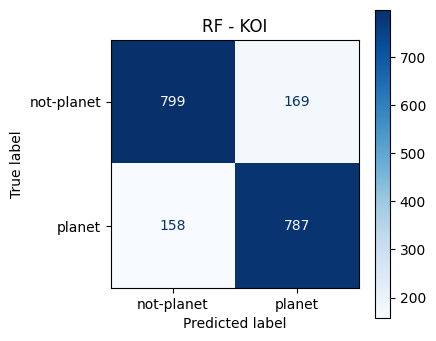


Fitting XGBoost...


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


XGBoost training time: 0.387 sec

XGBoost results:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       968
           1       0.81      0.81      0.81       945

    accuracy                           0.81      1913
   macro avg       0.81      0.81      0.81      1913
weighted avg       0.81      0.81      0.81      1913

ROC AUC: 0.8991544230180594


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


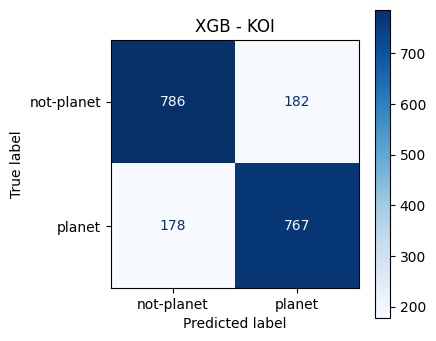

Could not extract feature importances: All arrays must be of the same length

########### TOI ###########
Basic stats: shape= (7703, 9) label_counts=
 label
1      5262
0      1197
CP      684
APC     462
FA       98
Name: count, dtype: int64
Training on TOI with features: ['period', 'duration', 'prad', 'depth', 'st_teff', 'st_rad', 'snr'] | samples: 6459

Fitting RandomForest...


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


RandomForest training time: 0.360 sec

RandomForest results:
              precision    recall  f1-score   support

           0       0.58      0.28      0.38       239
           1       0.85      0.95      0.90      1053

    accuracy                           0.83      1292
   macro avg       0.72      0.62      0.64      1292
weighted avg       0.80      0.83      0.80      1292

ROC AUC: 0.8249969205338801


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


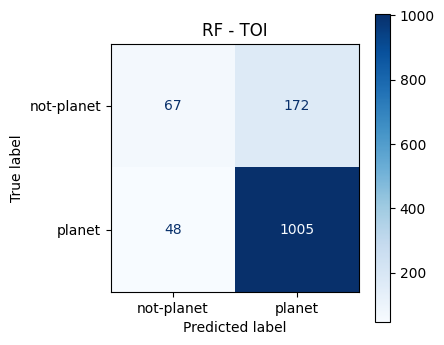


Fitting XGBoost...


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


XGBoost training time: 0.158 sec

XGBoost results:
              precision    recall  f1-score   support

           0       0.55      0.36      0.44       239
           1       0.87      0.93      0.90      1053

    accuracy                           0.83      1292
   macro avg       0.71      0.65      0.67      1292
weighted avg       0.81      0.83      0.81      1292

ROC AUC: 0.797303579730358


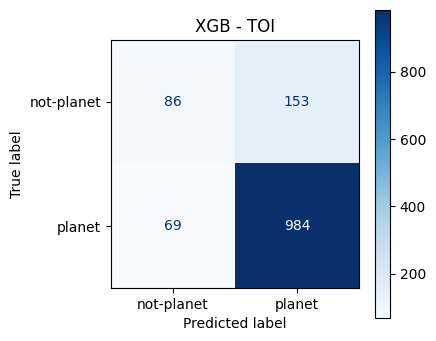

Could not extract feature importances: All arrays must be of the same length
K2 missing; skipping.

########### COMBINED ###########
Combined before filtering: (16023, 9)
Combined after filtering: (16023, 9)
Training on COMBINED with features: ['period', 'duration', 'prad', 'depth', 'st_teff', 'st_rad', 'snr'] | samples: 16023

Fitting RandomForest...
RandomForest training time: 0.569 sec

RandomForest results:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1207
           1       0.83      0.90      0.86      1998

    accuracy                           0.82      3205
   macro avg       0.82      0.80      0.81      3205
weighted avg       0.82      0.82      0.82      3205

ROC AUC: 0.8895587799896003


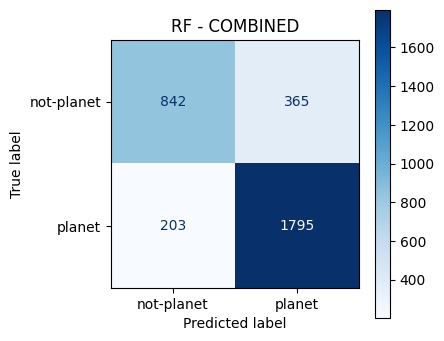


Fitting XGBoost...
XGBoost training time: 0.223 sec

XGBoost results:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1207
           1       0.83      0.88      0.86      1998

    accuracy                           0.82      3205
   macro avg       0.81      0.80      0.80      3205
weighted avg       0.82      0.82      0.82      3205

ROC AUC: 0.8771126138566073


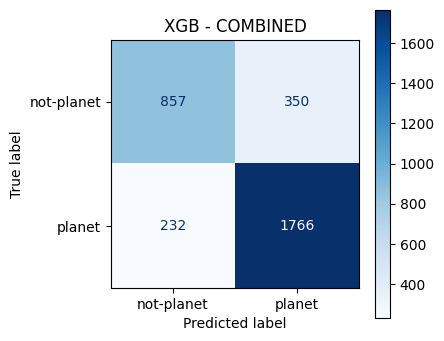

,rf,xgb
feature,,
prad,0.231216,0.274306
period,0.213741,0.171797
depth,0.153890,0.120777
duration,0.147426,0.115993
snr,0.124999,0.127812
st_rad,0.066989,0.104562
st_teff,0.061740,0.084753


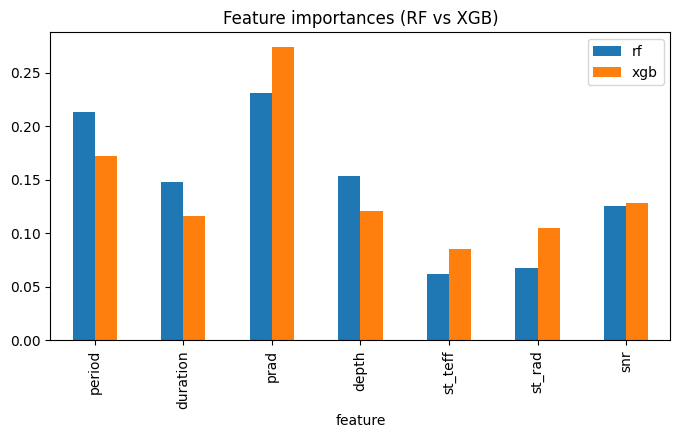


Saved comparison results to models/compare_results_rf_xgb.joblib


In [13]:

# Run comparisons for each dataset and for the combined dataset.
results = {}
for name, dfstd in [('KOI', std_koi), ('TOI', std_toi), ('K2', std_k2)]:
    if dfstd.empty:
        print(name, 'missing; skipping.')
        continue
    print('\n###########', name, '###########')
    print('Basic stats: shape=', dfstd.shape, 'label_counts=\n', dfstd['label'].value_counts(dropna=False))
    res = train_compare(dfstd, name=name, balance_method=None)
    results[name] = res

# Combined dataset
combined = pd.concat([d for d in [std_koi, std_toi, std_k2] if not d.empty], ignore_index=True)
combined = combined.dropna(subset=['label'])
combined = combined[combined['label'].isin([0,1])].copy()
print('\n########### COMBINED ###########')
print('Combined before filtering:', combined.shape)
combined = combined.dropna(thresh=2, subset=['period','duration','prad','depth','st_teff','st_rad','snr'])
print('Combined after filtering:', combined.shape)
res_combined = train_compare(combined, name='COMBINED', balance_method=None)
results['COMBINED'] = res_combined

# Save results
import joblib, os
os.makedirs('models', exist_ok=True)
joblib.dump(results, 'models/compare_results_rf_xgb.joblib')
print('\nSaved comparison results to models/compare_results_rf_xgb.joblib')
